# Lab 5 - Calibração de câmeras
Neste laboratório, vamos utilizar os conceitos aprendidos em aula para calibrar uma câmera e retirar a distorção da lente. Para isso, precisaremos de utilizar essa câmera para tirar várias fotos do padrão de calibração em posições e orientações diferentes.

Tutorial do OpenCV: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

##Calibração de câmeras

In [ ]:
import numpy as np
import cv2
import glob                                  # Funcoes para importar os nomes dos arquivos de imagens
import plotly.graph_objects as go            # Plotly
from plotly.subplots import make_subplots    # Subplots no Plotly
import matplotlib.pyplot as plt              # Matplotlib

###Leitura das imagens e detecção dos pontos

In [ ]:
# Parametros do tabuleiro de xadrez (tamanho, numero de linhas e colunas)
tam_quadrado = 50
l = 7
c = 10

# Criacao do objeto de pontos 3D, como: [[0,0,0], [1,0,0], [2,0,0] ..., [6,5,0]]
pts_padrao = np.zeros((l*c,3), np.float32)
pts_padrao[:,:2] = np.mgrid[0:c*tam_quadrado:tam_quadrado,0:l*tam_quadrado:tam_quadrado].T.reshape(-1,2)

# Vetores para armazenar os pontos 3D e 2D de todas as imagens
pts3D = []    # Pontos 3D no mundo real
pts2D = []    # Pontos 2D no plano da imagem

# Criterio de termino para refinamento dos cantos detectados
criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Leitura das imagens para a calibracao
imagens = glob.glob('*.jpg')
# Conferindo o numero de imagens lidas
print('Numero de imagens lidas: ', len(imagens))

# Ler imagens, detectar as quinas, refinar para a precisao de subpixel e plotar as quinas detectadas
for nome_img in imagens:
    # Le a imagem e converte para escala de cinza
    img = cv2.imread(nome_img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Encontra as quinas do tabuleiro
    ret, corners = cv2.findChessboardCorners(gray, (c,l), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FILTER_QUADS)

    # Se encontradas, adiciona os pontos aos objetos (apos refinadas as quinas)
    if ret == True:
        corners_subpixel = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criterio)

        pts3D.append(pts_padrao)
        pts2D.append(corners_subpixel)

        # Converte de BGR para RGB para mostrar a imagem com o matplotlib.pyplot
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Desenha os pontos e mostra as quinas
        img = cv2.drawChessboardCorners(img, (c,l), corners_subpixel, ret)

        # Quando usando o Colab, nao podemos usar cv2.imshow. Entao, mostramos
        # as imagens com o matplotlib.pyplot
        fig = plt.figure(figsize=(10,10))
        plt.imshow(img)

        #cv2.imshow('img',img)
        #cv2.waitKey(100)
        #cv2.destroyAllWindows()
plt.show()

# Informa o numero de imagens em que foram detectados os pontos das quinas
print('Numero de imagens com quinas detectadas:', len(pts3D))

Output hidden; open in https://colab.research.google.com to view.

### Calibração da câmera

In [ ]:
# Rodar a calibracao de camera retorna: ret (flag), K (parametros intrinsecos),
# dist (coeficientes de distorcao), rvecs e tvecs (vetores de rotacao e translacao)
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(pts3D, pts2D, gray.shape[::-1], None, None)

# Printar os resultados da calibracao
print('Matriz de parametros intrinsecos: \n', K)
print('Coeficientes de distorcao radial:', dist)

# Organizar os parametros extrinsecos (rotacao e translacao) em vetores 3xN, em que N e o numero de imagens
transl = np.hstack(tvecs)
rot = np.hstack(rvecs)

Matriz de parametros intrinsecos: 
 [[833.14241738   0.         286.92102763]
 [  0.         831.99303026 272.98721081]
 [  0.           0.           1.        ]]
Coeficientes de distorcao radial: [[ 0.23701885 -1.37702912 -0.00307954 -0.01165393  2.38870246]]


### Apresentação dos parâmetros extrínsecos

In [ ]:
# Representacao da camera parada e o padrao em movimento
pontos_cam = np.array([[0,100,0,0],[0,0,100,0],[0,0,0,100],[1,1,1,1]])

trace_cam_x = go.Scatter3d(x=pontos_cam[0,:2],
                           y=pontos_cam[1,:2],
                           z=pontos_cam[2,:2],
                           mode='lines',
                           line=dict(color='red',width=4))
trace_cam_y = go.Scatter3d(x=pontos_cam[0,:4:2],
                           y=pontos_cam[1,:4:2],
                           z=pontos_cam[2,:4:2],
                           mode='lines',
                           line=dict(color='green',width=4))
trace_cam_z = go.Scatter3d(x=pontos_cam[0,:4:3],
                           y=pontos_cam[1,:4:3],
                           z=pontos_cam[2,:4:3],
                           mode='lines',
                           line=dict(color='blue',width=4))

fig = go.Figure(data=[trace_cam_x,trace_cam_y,trace_cam_z])

# Plota os padroes de calibracao considerando a camera fixa em (0,0,0)
for i in range(rot.shape[1]):
    R,_ = cv2.Rodrigues(rot[:,i])
    Xrot = R[0,:]@pts_padrao.T + transl[0,i]
    Yrot = R[1,:]@pts_padrao.T + transl[1,i]
    Zrot = R[2,:]@pts_padrao.T + transl[2,i]
    fig.add_trace(go.Scatter3d(x=Xrot,y=Yrot,z=Zrot,mode='markers',marker=dict(size=4)))#,color='black'

fig.update_layout(scene = dict(
                  xaxis_title='X',
                  yaxis_title='Y',
                  zaxis_title='Z',
                  aspectmode='cube'
                  ,camera=dict(up=dict(x=0, y=-1, z=0),
                               eye=dict(x=0,y=0,z=-2))
                  ),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()

### Exportando os parâmetros de calibração

In [ ]:
# Salvar a matriz de parametros intrinsecos e de coeficientes de distorcao em um arquivo .npz
np.savez('calib_lab5.npz', K=K, dist=dist, rvecs=rvecs, tvecs=tvecs)

# Baixar os arquivos se necessario
#from google.colab import files
#files.download('calib_lab5.npz')

Caso queira carregar os parâmetros salvos de um arquivo, aqui vão duas formas:

In [ ]:
# Maneira 1:
with np.load('calib_lab5.npz') as X:
    K, dist, _, _ = [X[i] for i in ('K','dist','rvecs','tvecs')]

# Maneira 2:
dados_lab5 = np.load('calib_lab5.npz')
K = dados_lab5['K']
dist = dados_lab5['dist']

## Retirando a distorção

Com a calibração da câmera, podemos retirar a distorção das imagens causada pelas lentes.

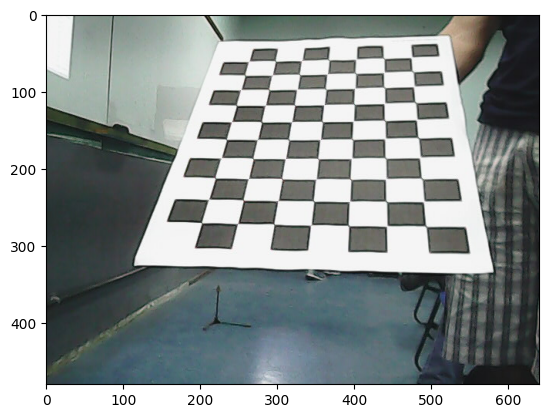

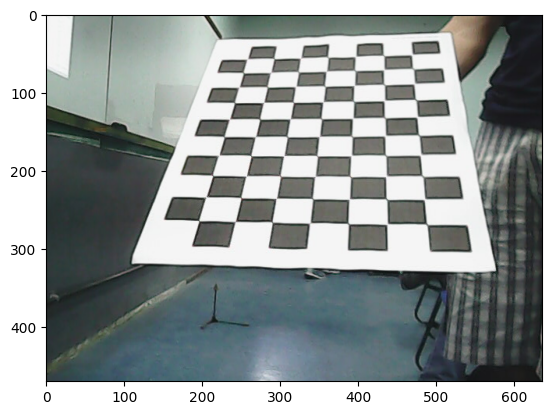

In [49]:
# Importacao dos parametros da camera
dados_lab5 = np.load('calib_lab5.npz')
K = dados_lab5['K']
dist = dados_lab5['dist']

# Leitura de uma das imagens
imagens = glob.glob('*.jpg')
img = cv2.imread(imagens[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# Definição do novo tamanho da imagem (anterior: h linhas e w colunas)
escala = 1			    # Caso a distorção seja muito grande, a função de undistort diminuirá muito a imagem
h1=int(escala*h)		# e a escala aumentará a imagem novamente
w1=int(escala*w)

# Corrige a matriz K para levar em consideração a nova imagem sem distorção (com novo tamanho e novo centro)
novaK, roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w1,h1))
x,y,_,_ = roi
novaK[0,2] = novaK[0,2]-x	# Correção para o novo centro da imagem
novaK[1,2] = novaK[1,2]-y

# Retira a distorção da imagem e corta a imagem
dst = cv2.undistort(img, K, dist, None, novaK)
x,y,w,h = roi
dst = dst[0:h, 0:w,:]	# Recortando a imagem para ter o tamanho definido pelo roi

plt.imshow(img)
fig = plt.figure()
plt.imshow(dst)
plt.show()

Também podemos descobrir onde um pixel da imagem distorcida estará na imagem sem distorção com a função **undistortPoints**!

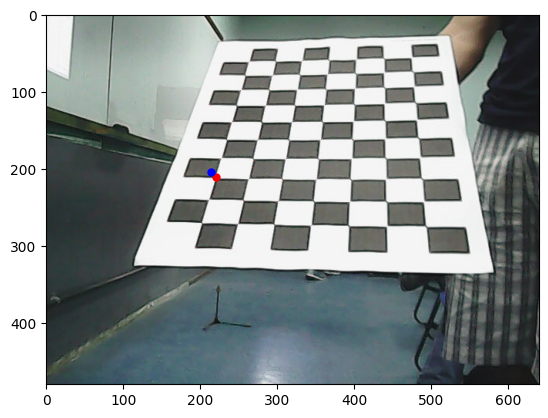

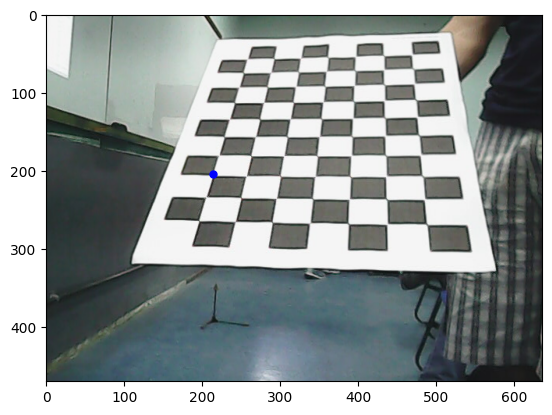

In [51]:
# Importacao dos parametros da camera
dados_lab5 = np.load('calib_lab5.npz')
K = dados_lab5['K']
dist = dados_lab5['dist']

# Leitura de uma das imagens
imagens = glob.glob('*.jpg')
img = cv2.imread(imagens[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# Definição do novo tamanho da imagem (anterior: h linhas e w colunas)
escala = 1			    # Caso a distorção seja muito grande, a função de undistort diminuirá muito a imagem
h1=int(escala*h)		# e a escala aumentará a imagem novamente
w1=int(escala*w)

# Corrige a matriz K para levar em consideração a nova imagem sem distorção (com novo tamanho e novo centro)
novaK, roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w1,h1))
x,y,_,_ = roi
novaK[0,2] = novaK[0,2]-x	# Correção para o novo centro da imagem
novaK[1,2] = novaK[1,2]-y

# Retira a distorção da imagem e corta a imagem
dst = cv2.undistort(img, K, dist, None, novaK)
x,y,w,h = roi
dst = dst[0:h, 0:w,:]	# Recortando a imagem para ter o tamanho definido pelo roi

pontos = np.array([[220,210]], dtype=np.float32)
pontos_corrigidos = cv2.undistortPoints(pontos, K, dist, None, novaK).squeeze(axis=0)

plt.imshow(img)
plt.plot(pontos[:,0], pontos[:,1], 'ro', markersize=5)  # Desenha um ponto vermelho
plt.plot(pontos_corrigidos[:,0], pontos_corrigidos[:,1], 'bo', markersize=5)  # Desenha um ponto vermelho
fig = plt.figure()
plt.imshow(dst)
plt.plot(pontos_corrigidos[:,0], pontos_corrigidos[:,1], 'bo', markersize=5)  # Desenha um ponto vermelho
plt.show()

## Seu momento de brilhar!

Teste agora o seu algoritmo de calibração com alguma câmera! Calibre essa câmera e tente projetar em uma das fotos os pontos do padrão para checar se a sua calibração está boa. Não esqueça de retirar a distorção das imagens!

In [ ]:
# Escreva seu código aqui